In [139]:
import os
import sys
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.linalg import expm
from sklearn.metrics import _regression

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

from src.datasets import simulate_two_tank
from src.plot import plot_eigs, plot_results, set_size

%load_ext autoreload
%autoreload 2

seed = 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [127]:
delay = 20
n_samples = 20000
model, (train_raw, dev_raw, test_raw) = simulate_two_tank(
    n_samples, n_sequences=3, delay=delay
)
_, (train_data, dev_data, test_data) = simulate_two_tank(
    n_samples, n_sequences=3, delay=delay, noise_variance=0.1, seed=seed
)

In [143]:
start = 80
Y_derek_pred = np.load("results/test_pred_derek.npy")
end = min(500, len(Y_derek_pred) + start)

with open("data/y_eDMDc.pkl", "rb") as fp:
    Y_eDMDcs_pred = pickle.load(fp)

## Tracking

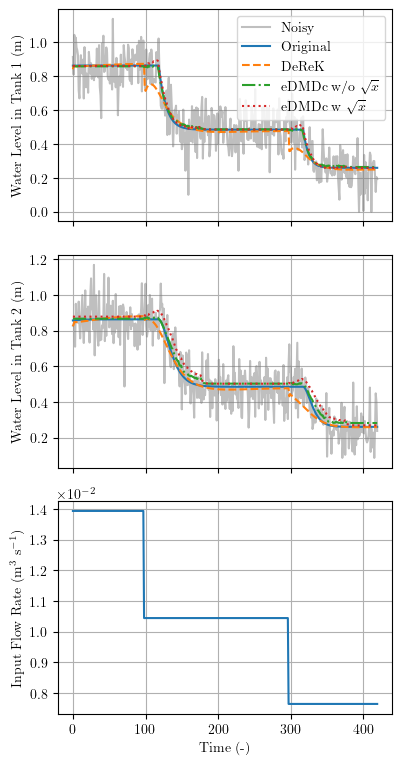

In [150]:
# [donotremove]
fig = plot_results(
    test_data["U"][start:end],
    {
        "Noisy": test_data["Y"][start:end],
        "Original": test_raw["Y"][start:end],
        "DeReK": Y_derek_pred[: end - start],
        **{name: Y_pred[start:end] for name, Y_pred in Y_eDMDcs_pred.items()},
    },
)
fig.savefig("results/two_tank_results.pdf")

In [147]:
def regression_report(y_true, y_pred):
    report = {}
    metrics = _regression.__ALL__
    for name in metrics:
        try:
            metric = getattr(_regression, name)(y_true, y_pred)
            report[name] = metric
        except Exception as e:
            pass
    return report


stats_ = {}
stats_["DeReK"] = regression_report(
    test_raw["Y"][start:end], Y_derek_pred[: end - start]
)
for name, Y_pred in Y_eDMDcs_pred.items():
    stats_[name] = regression_report(
        test_raw["Y"][start:end], Y_pred[start:end]
    )

pd.DataFrame(stats_).round(4)

,DeReK,eDMDc w/o $\sqrt{x}$,eDMDc w $\sqrt{x}$
mean_absolute_error,0.0193,0.0113,0.0180
mean_squared_error,0.0013,0.0002,0.0008
mean_squared_log_error,0.0005,0.0001,0.0003
median_absolute_error,0.0102,0.0112,0.0098
mean_absolute_percentage_error,0.0361,0.0269,0.0381
mean_pinball_loss,0.0097,0.0057,0.0090
r2_score,0.9741,0.9954,0.9836
root_mean_squared_log_error,0.0226,0.0093,0.0157
root_mean_squared_error,0.0349,0.0136,0.0239
explained_variance_score,0.9783,0.9984,0.9935


## Eigenvalues

In [80]:
# Original
A = model.compute_A(model.stats["Y"]["mean"])
A_d = expm(A * model.ts)
eig_original, _ = np.linalg.eig(A_d)
eig_original = eig_original[np.argsort(eig_original)[::-1]]

# Load DeReK's A matrix
eig_derek = np.load("results/eig_derek.npy")

# Load eigenvalues and amplitudes of eDMD wo sqrt
eig_edmd_wo_sqrt = np.load("results/eig_eDMDc wo sqrtx.npy")
amp_edmd_wo_sqrt = np.load("results/amplitudes_eDMDc wo sqrtx.npy")

# Load eigenvalues and amplitudes of eDMD w sqrt
eig_edmd_w_sqrt = np.load("results/eig_eDMDc w sqrtx.npy")
amp_edmd_w_sqrt = np.load("results/amplitudes_eDMDc w sqrtx.npy")

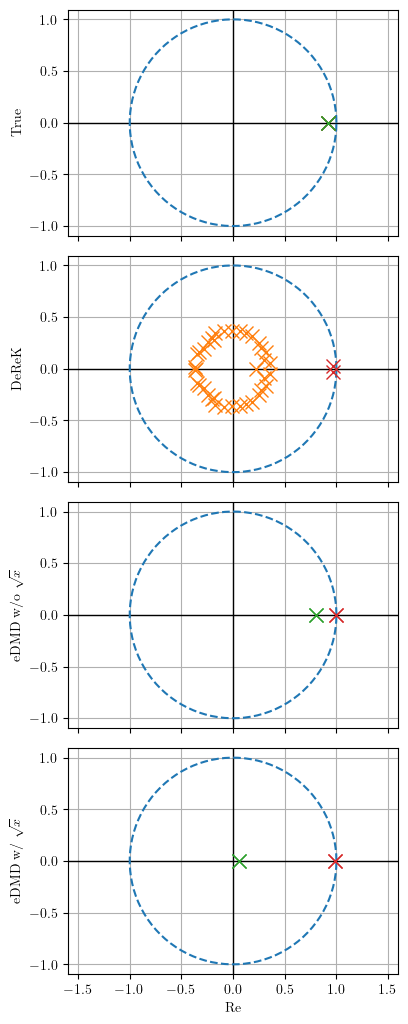

In [149]:
# [donotremove]
fig, axs = plt.subplots(
    4,
    1,
    figsize=set_size("ieee", subplots=(4, 1)),
    sharex=True,
)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

plot_eigs(eig_original, ax=axs[0])
plot_eigs(eig_derek, ax=axs[1])
plot_eigs(eig_edmd_wo_sqrt, ax=axs[2])
plot_eigs(eig_edmd_w_sqrt, ax=axs[3])
axs[0].set_ylabel("True")
axs[1].set_ylabel("DeReK")
axs[2].set_ylabel("eDMD w/o $\\sqrt{x}$")
axs[3].set_ylabel("eDMD w/ $\\sqrt{x}$")
axs[-1].set_xlabel("Re")

fig.tight_layout()

for ax in axs:
    ax.set_xlim(-1.6, 1.6)
#     ax.set_ylim(-1.1, 1.1)
fig.savefig("results/eigenvalues_comparison.pdf")